In [1]:
import torch
import numpy as np
import time
import torchvision
from torch import nn,optim
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
eta=0.4
def adagrad_2d(x1,x2,s1,s2):
    g1=0.2*x1
    g2=4*x2
    eps=1e-6
    s1+=g1**2
    s2+=g2**2
    x1 -= g1*eta/np.sqrt(s1+eps)
    x2 -= g2*eta/np.sqrt(s2+eps)
    return x1,x2,s1,s2

In [3]:
def train_2d(trainer):
    x1,x2,s1,s2=-5,-2,0,0
    result=[(x1,x2)]
    for i in range(20):
        x1 ,x2,s1,s2=trainer(x1,x2,s1,s2)
        result.append((x1,x2))
#     print(result)
    return result
        

In [4]:
def f_2d(x1,x2):
    return 0.1*x1**2+2*x2**2

In [5]:
def show_trace_2d(f,result):
    plt.plot(*zip(*result),'r-o')
    x1,x2=np.meshgrid(np.arange(-5.5,1.0,0.1),np.arange(-3.0,1.0,0.1))
    plt.contour(x1,x2,f(x1,x2))

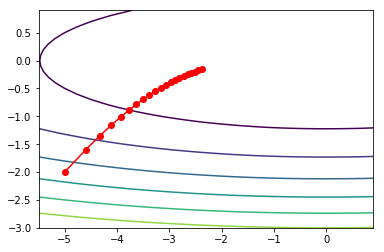

In [6]:
eta=0.4
show_trace_2d(f_2d,train_2d(adagrad_2d))

In [7]:
eta=2
# show_trace_2d(f_2d,train_2d(adagrad_2d))

step-by-step Adagrad

In [8]:
def get_data_ch7():
    data=np.genfromtxt(r'F:\study\ml\DataSet\airfoil_self_noise\airfoil_self_noise.dat',
                      delimiter='\t')
    data=(data-data.mean(axis=0)) / data.std(axis=0)
    features=torch.tensor(data[:1500,:-1],dtype=torch.float32)
    labels=torch.tensor(data[:1500,-1],dtype=torch.float32)
    return features,labels

In [9]:
features,labels=get_data_ch7()
features.shape

torch.Size([1500, 5])

In [10]:
def init_adagrad():
    s_w=torch.zeros((features.shape[1],1),dtype=torch.float32)
    s_b=torch.zeros(1,dtype=torch.float32)
    return (s_w,s_b)

In [19]:
eps=1e-6
def adagrad_sgd(params,states,hyperparams):
    eps=1e-6
    for p,s in zip(params,states):
        s.data += p.grad.data*p.grad.data
        p.data -= hyperparams['lr']/torch.sqrt(s.data+eps) * p.grad.data

In [20]:
def linreg(x,w,b):
    return torch.mm(x,w)+b

def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.shape))**2

In [21]:
def train_ch7(optimizer_fn,states,hyperparams,features,labels,
             batch_size=10,num_epochs=2):
    net,loss=linreg,squared_loss
    
    w=torch.nn.Parameter(torch.tensor(np.random.normal(
    0,0.01,size=(features.shape[1],1)),dtype=torch.float32,requires_grad=True))
    
    b=torch.nn.Parameter(torch.tensor(np.zeros(1),dtype=torch.float32,requires_grad=True))
    
    data_iter=torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(features,labels),batch_size=batch_size,
    shuffle=True)
    
    def eval_loss():
        return loss(net(features,w,b),labels).mean().item() /2
    
    ls = [eval_loss()]
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=loss(net(X,w,b),y).mean() /2
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            optimizer_fn([w,b],states,hyperparams)
            if (batch_i+1) * batch_size % 100 ==0:
                ls.append(eval_loss())
    print('loss : %f , %f sec per epoch' % (ls[-1],time.time()-start))
#     print(ls)
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs')
    plt.ylabel('loss')
            

loss : 0.242009 , 0.069004 sec per epoch


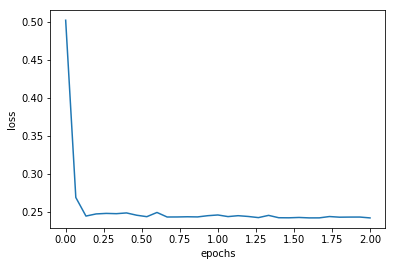

In [22]:
train_ch7(adagrad_sgd,init_adagrad(),{'lr':0.1},features,labels)

In [23]:
def train_pytorch_ch7(optimizer_fn,hyperparams,features,labels,batch_size=10,
                     num_epochs=2):
    net=nn.Sequential(nn.Linear(features.shape[1],1))
    loss=nn.MSELoss()
    
    optimizer=optimizer_fn(net.parameters(),**hyperparams)
    
    data_iter=torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(features,labels),batch_size=batch_size,
    shuffle=True)
    
    def eval_loss():
        return loss(net(features).view(-1),labels).item() /2
    
    ls = [eval_loss()]
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=loss(net(features).view(-1),labels) /2
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i+1) * batch_size % 100 ==0:
                ls.append(eval_loss())
    print('loss : %f , %f sec per epoch' % (ls[-1],time.time()-start))
#     print(ls)
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs')
    plt.ylabel('loss')

loss : 0.241688 , 0.060004 sec per epoch


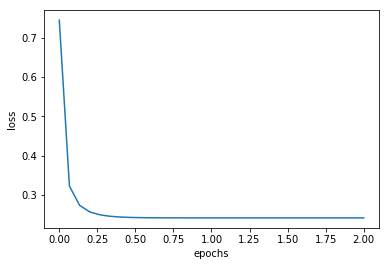

In [16]:
train_pytorch_ch7(torch.optim.Adagrad,{'lr':0.1},features,labels)

In [ ]:
def train_pytorch_ch7()